In [1]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import  cv2
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from numpy import trapz
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.applications.resnet import ResNet101

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import keras
from keras.layers import Input,Conv2D,Activation,Dense,Lambda,Flatten,Embedding,PReLU,BatchNormalization,Dropout
from keras.models import Model
import keras.backend as K
from keras.utils import to_categorical
import numpy as np
from keras.callbacks import EarlyStopping

from keras.applications.densenet import DenseNet201

from tensorflow.keras import layers, losses, optimizers, metrics

<h2>Model</h2>

In [2]:
class Models():
  def __init__(self,shape,features_dims,num_classes):
      self.shape = shape
      self.features_dims = features_dims
      self.num_classes = num_classes
  def Resnet50(self):
    resnet_50 = ResNet50(weights='imagenet', include_top=False)
    resnet_50.trainable=False
    inputs = Input(self.shape)
    x = resnet_50(inputs)
    x = GlobalAveragePooling2D()(x)
    # x = Dropout(0.3)(x)
    features = Dense(self.features_dims, activation="relu", name="features")(x)
    outputs =Dense(self.num_classes, activation="softmax")(features)
    return Model(inputs, [features, outputs])

  def Resnet101(self):
      resnet_101 = ResNet101(weights='imagenet', include_top=False)
      resnet_101.trainable=False
      inputs = Input(self.shape)
      x = resnet_101(inputs)
      x = GlobalAveragePooling2D()(x)
      features = Dense(self.features_dims, activation="relu", name="features")(x)
      outputs =Dense(self.num_classes, activation="softmax")(features)
      return Model(inputs, [features, outputs])

  def DenseNet201(self):
      densenet_201 =  DenseNet201(weights='imagenet', include_top=False)
      densenet_201.trainable=False
      inputs = Input(self.shape)
      x = densenet_201(inputs)
      x = GlobalAveragePooling2D()(x)
      # x = Dropout(0.3)(x)
      features = Dense(self.features_dims, activation="relu", name="features")(x)
      outputs =Dense(num_classes, activation="softmax")(features)
      return Model(inputs, [features, outputs])


<h2>Prepare data</h2>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
with open('/content/drive/MyDrive/resized_train_data.pickle', 'rb') as f:
    x_train, y_train = pickle.load(f)

In [5]:
with open('/content/drive/MyDrive/resized_valid_data.pickle', 'rb') as f:
    x_valid, y_valid = pickle.load(f)

In [6]:
y_train_one_hot=to_categorical(y_train)
y_valid_one_hot=to_categorical(y_valid)

print(x_train.shape)
print(y_train.shape)
print(y_valid_one_hot.shape)

(14569, 72, 72, 3)
(14569,)
(5440, 80)


In [7]:
def shufflerandom(x_,y_,y_one_hot):
  indices = np.arange(len(y_))
  np.random.shuffle(indices)
  x_ = x_[indices]
  y_one_hot = y_one_hot[indices]
  y_ = y_[indices]

In [8]:
shufflerandom(x_train,y_train,y_train_one_hot)
shufflerandom(x_valid,y_valid,y_valid_one_hot)

In [9]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_train /= 255
x_valid /= 255

<h2>Center Loss</h2>

In [10]:
class CenterLoss(losses.Loss):
    def __init__(self, num_classes, feature_dims, alpha=0.5, reduction=losses.Reduction.AUTO, name='center_loss'):
        super(CenterLoss, self).__init__(reduction=reduction, name=name)

        self.num_classes = num_classes
        self.feature_dims = feature_dims

        # hyper parameter for updating the center point
        self.alpha = alpha

        self.centers = tf.Variable(tf.zeros(shape = (self.num_classes, self.feature_dims)))


    def call(self, y_true, y_pred):
        """
            y_ture : same teacher signal as for classification (1-hot vector)
                     shape = (batch_size, num_classes)
            y_pred : output of features in the middle layer of the model
                     shape = (batch_size, feature_dims)
        """

        labels = tf.argmax(y_true, axis=-1)

        centers_batch = tf.gather(self.centers, labels)

        diff = centers_batch - y_pred

        loss = tf.reduce_mean(tf.square(diff))


        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])

        diff = diff / tf.cast((1 + appear_times), tf.float32)

        diff = self.alpha * diff

        self.centers = tf.compat.v1.scatter_sub(self.centers, labels, diff)

        return loss

In [11]:
num_classes = 80
feature_dims = 2048

center_loss_obj = CenterLoss(num_classes, feature_dims)

In [12]:
def each_img_distance(y_true, y_pred):
    """
        y_true: true labels (1-hot vector)
        y_pred: predicted labels (output of features in the middle layer)

    """

    centers = center_loss_obj.centers  # Get the centers from center_loss_obj
    labels = tf.argmax(y_true, axis=-1)  # Retrieve the predicted labels by taking the index of the maximum value in y_true
    centers_batch = tf.gather(centers, labels)  # Gather the corresponding centers based on the predicted labels
    distances = tf.norm(y_pred - centers_batch, axis=1)  # Calculate the L2 (Euclidean) distance between y_pred and centers_batch

    return distances

In [13]:
def average_center_distance(y_true, y_pred):
    """
        y_true: true labels (1-hot vector)
        y_pred: predicted labels (output of features in the middle layer)

    """

    centers = center_loss_obj.centers  # Get the centers from the center_loss_obj
    num_centers = tf.shape(centers)[0]  # Get the number of centers

    # Calculate pairwise Euclidean distances between centers
    tiled_centers = tf.tile(tf.expand_dims(centers, axis=1), [1, num_centers, 1])  # Tile the centers to create pairs
    pairwise_distances = tf.norm(tiled_centers - tf.expand_dims(centers, axis=0), axis=-1)  # Calculate Euclidean distances

    # Exclude self-distances and calculate average distance
    mask = tf.ones([num_centers, num_centers]) - tf.eye(num_centers)  # Create a mask to exclude self-distances
    valid_distances = tf.boolean_mask(pairwise_distances, tf.cast(mask, tf.bool))  # Apply mask to exclude self-distances
    avg_distance = tf.reduce_mean(valid_distances)  # Calculate the average distance

    return avg_distance

In [14]:
shape = (72, 72,3)
features_dims = 2048
num_classes = 80

model_builder = Models(shape, features_dims, num_classes)

model = model_builder.Resnet50()



model.compile(optimizer="adam",
              loss=[center_loss_obj, losses.CategoricalCrossentropy()],
              metrics=[[each_img_distance, average_center_distance, metrics.CategoricalAccuracy()], [metrics.CategoricalAccuracy()]])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 features (Dense)            (None, 2048)              4196352   
                                                                 
 dense_2 (Dense)             (None, 80)                163920    
                                                                 
Total params: 27,947,984
Trainable params: 4,360,272
Non-trainable params: 23,587,712
_______________________________________

In [ ]:
print(x_train.shape,y_train_one_hot.shape,)

(14569, 72, 72, 3) (14569, 80)


In [ ]:
history_with_centerloss1 = model.fit(
    x_train,
    y_train_one_hot,
    validation_data=(x_valid,y_valid_one_hot),
    epochs=5,
    batch_size=32,
)

Epoch 1/5
456/456 [==============================] - 29s 54ms/step - loss: 4.2313 - features_loss: 0.0070 - dense_2_loss: 4.2242 - features_each_img_distance: 2.3080 - features_average_center_distance: 2.4707 - features_categorical_accuracy: 0.0000e+00 - dense_2_categorical_accuracy: 0.0355 - val_loss: 4.0678 - val_features_loss: 0.0047 - val_dense_2_loss: 4.0632 - val_features_each_img_distance: 2.5138 - val_features_average_center_distance: 2.6991 - val_features_categorical_accuracy: 0.0000e+00 - val_dense_2_categorical_accuracy: 0.0664
Epoch 2/5
456/456 [==============================] - 15s 33ms/step - loss: 3.9552 - features_loss: 0.0072 - dense_2_loss: 3.9481 - features_each_img_distance: 2.7071 - features_average_center_distance: 3.1467 - features_categorical_accuracy: 0.0000e+00 - dense_2_categorical_accuracy: 0.0793 - val_loss: 3.8607 - val_features_loss: 0.0073 - val_dense_2_loss: 3.8535 - val_features_each_img_distance: 3.2928 - val_features_average_center_distance: 3.3247 -

In [ ]:
model.trainable = True

model.compile(keras.optimizers.Adam(1e-5),
              loss=[center_loss_obj, losses.CategoricalCrossentropy()],
              metrics=[[each_img_distance, average_center_distance, metrics.CategoricalAccuracy()], [metrics.CategoricalAccuracy()]])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 features (Dense)            (None, 2048)              4196352   
                                                                 
 dense_2 (Dense)             (None, 80)                163920    
                                                                 
Total params: 27,947,984
Trainable params: 27,894,864
Non-trainable params: 53,120
__________________________________________

In [ ]:
history_with_centerloss1 = model.fit(
    x_train,
    y_train_one_hot,
    validation_data=(x_valid,y_valid_one_hot),
    epochs=50,
    batch_size=32,
)

Epoch 1/50
456/456 [==============================] - 44s 84ms/step - loss: 8.5462 - features_loss: 0.3146 - dense_2_loss: 8.2315 - features_each_img_distance: 16.0188 - features_average_center_distance: 17.3962 - features_categorical_accuracy: 0.0000e+00 - dense_2_categorical_accuracy: 0.0771 - val_loss: 136.1408 - val_features_loss: 51.5723 - val_dense_2_loss: 84.5686 - val_features_each_img_distance: 190.7948 - val_features_average_center_distance: 149.3380 - val_features_categorical_accuracy: 0.0000e+00 - val_dense_2_categorical_accuracy: 0.0136
Epoch 2/50
456/456 [==============================] - 36s 80ms/step - loss: 4.1492 - features_loss: 1.0250 - dense_2_loss: 3.1242 - features_each_img_distance: 14.6134 - features_average_center_distance: 15.1431 - features_categorical_accuracy: 0.0000e+00 - dense_2_categorical_accuracy: 0.2363 - val_loss: 4.9074 - val_features_loss: 0.5849 - val_dense_2_loss: 4.3226 - val_features_each_img_distance: 19.3844 - val_features_average_center_dis

In [ ]:
model.save_weights('/content/drive/MyDrive/centerloss.h5')

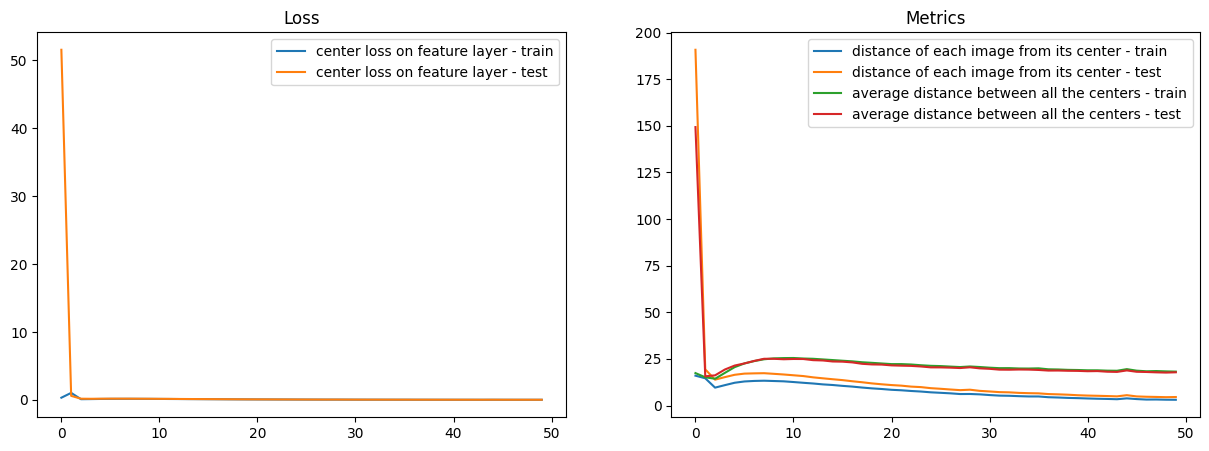

In [ ]:
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history_with_centerloss1.history["features_loss"], label = "center loss on feature layer - train")
ax.plot(history_with_centerloss1.history["val_features_loss"], label = "center loss on feature layer - test")
ax.set_title("Loss")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_with_centerloss1.history["features_each_img_distance"], label = "distance of each image from its center - train")
ax.plot(history_with_centerloss1.history["val_features_each_img_distance"], label = "distance of each image from its center - test")
ax.plot(history_with_centerloss1.history["features_average_center_distance"], label = "average distance between all the centers - train")
ax.plot(history_with_centerloss1.history["val_features_average_center_distance"], label = "average distance between all the centers - test")
ax.set_title("Metrics")
ax.legend()

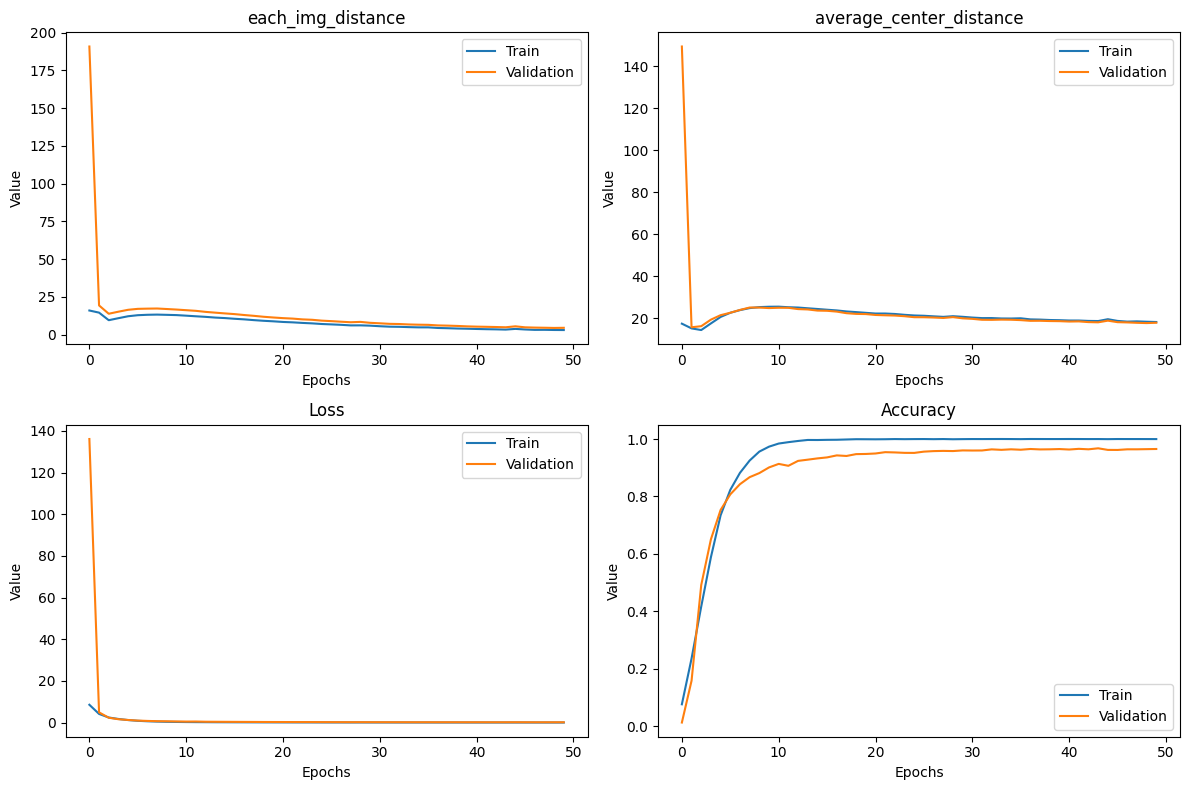

In [ ]:
import matplotlib.pyplot as plt

# استخراج مقادیر متریک‌ها از تاریخچه
each_img_distance_train = history_with_centerloss1.history['features_each_img_distance']
average_center_distance_train = history_with_centerloss1.history['features_average_center_distance']
loss_train = history_with_centerloss1.history['loss']
accuracy_train = history_with_centerloss1.history['dense_2_categorical_accuracy']

each_img_distance_val = history_with_centerloss1.history['val_features_each_img_distance']
average_center_distance_val = history_with_centerloss1.history['val_features_average_center_distance']
loss_val = history_with_centerloss1.history['val_loss']
accuracy_val = history_with_centerloss1.history['val_dense_2_categorical_accuracy']


fig, axes = plt.subplots(2, 2, figsize=(12, 8))


axes[0, 0].plot(each_img_distance_train, label='Train')
axes[0, 0].plot(each_img_distance_val, label='Validation')
axes[0, 0].set_title('each_img_distance')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()


axes[0, 1].plot(average_center_distance_train, label='Train')
axes[0, 1].plot(average_center_distance_val, label='Validation')
axes[0, 1].set_title('average_center_distance')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Value')
axes[0, 1].legend()


axes[1, 0].plot(loss_train, label='Train')
axes[1, 0].plot(loss_val, label='Validation')
axes[1, 0].set_title('Loss')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()


axes[1, 1].plot(accuracy_train, label='Train')
axes[1, 1].plot(accuracy_val, label='Validation')
axes[1, 1].set_title('Accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()


plt.tight_layout()

<h2>Load Model</h2>

In [15]:
model_builder1 = Models(shape, features_dims, num_classes)

model = model_builder1.Resnet50()
model.trainable=True
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 features (Dense)            (None, 2048)              4196352   
                                                                 
 dense_3 (Dense)             (None, 80)                163920    
                                                                 
Total params: 27,947,984
Trainable params: 27,894,864
Non-trainable params: 53,120
__________________________________________

In [18]:
model.load_weights('/content/drive/MyDrive/centerloss.h5')

In [22]:
feature_extractor = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('features').output)

In [18]:
# Load the feature extractor model
feature_extractor = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('features').output)
# feature_extractor1 = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('features').output)
features=feature_extractor.predict(x_valid)
# feature_extractor1.predict(x_valid)
# are_equal = np.allclose(feature_extractor, feature_extractor1)
# print(are_equal)


170/170 [==============================] - 8s 20ms/step


In [41]:
features.shape

(5440, 2048)

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_vectors = tsne.fit_transform(features)
# tsne_centers=  tsne.fit_transform(center_loss_obj.centers)


In [73]:
print(center_loss_obj.centers[0])

tf.Tensor(
[2.5278434e-02 2.3338150e-03 8.9301565e-04 ... 1.3507958e-01 2.3335249e+00
 3.0531641e-04], shape=(2048,), dtype=float32)


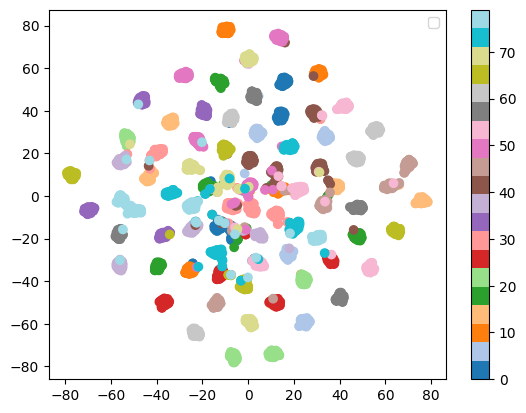

In [20]:
import matplotlib.pyplot as plt

plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], c=y_valid, cmap='tab20')
# plt.scatter(tsne_centers[:, 0], tsne_centers[:, 1], c='red', marker='x', label='Centers')
plt.colorbar()
plt.legend()
plt.show()

In [19]:
with open('/content/drive/MyDrive/resized_test_data.pickle', 'rb') as f:
    x_test, y_test = pickle.load(f)

In [20]:
# imgs=x_test.copy()
# labels=y_test.copy()

indices_1 =np.random.choice(np.where(y_test == 1)[0],size=500)
indices_0 =np.random.choice( np.where(y_test == 0)[0],size=500)
inc=np.concatenate([indices_1,indices_0])
# print(inc)

imgs=x_test[inc]
labels=y_test[inc]

print(imgs.shape,labels.shape)
print(labels)

(1000, 2, 72, 72, 3) (1000,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [23]:
similarities = np.zeros(len(imgs))
for i in range(len(imgs)):
    print(imgs[i][0].shape)
    image1 = np.expand_dims(imgs[i][0], axis=0)
    image2 = np.expand_dims(imgs[i][1], axis=0)
    image1=image1.astype('float32')
    image2=image2.astype('float32')

    image1/=255
    image2/=255
    print(image1.shape)
    features1 = feature_extractor.predict(image1)
    features2 = feature_extractor.predict(image2)
    print(features1.shape,features2.shape)
    similarity = cosine_similarity(features1, features2)
    similarities[i] = similarity[0, 0]
    print(i)
print(similarities)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
(1, 2048) (1, 2048)
194
(72, 72, 3)
(1, 72, 72, 3)
1/1 [==============================] - 0s 25ms/step
(1, 2048) (1, 2048)
195
(72, 72, 3)
(1, 72, 72, 3)
1/1 [==============================] - 0s 25ms/step
(1, 2048) (1, 2048)
196
(72, 72, 3)
(1, 72, 72, 3)
1/1 [==============================] - 0s 27ms/step
(1, 2048) (1, 2048)
197
(72, 72, 3)
(1, 72, 72, 3)
1/1 [==============================] - 0s 38ms/step
(1, 2048) (1, 2048)
198
(72, 72, 3)
(1, 72, 72, 3)
1/1 [==============================] - 0s 38ms/step
(1, 2048) (1, 2048)
199
(72, 72, 3)
(1, 72, 72, 3)
1/1 [==============================] - 0s 40ms/step
(1, 2048) (1, 2048)
200
(72, 72, 3)
(1, 72, 72, 3)
1/1 [==============================] - 0s 43ms/step
(1, 2048) (1, 2048)
201
(72, 72, 3)
(1, 72, 72, 3)
1/1 [==============================] - 0s 38ms/step
(1, 2048) (1, 2048)
202
(72, 72, 3)
(1, 72, 72, 3)
1/1 [=================

In [24]:
print(similarities[similarities<0.95])

[0.41267806 0.65190417 0.66185153 0.77581793 0.5942077  0.55570567
 0.64649403 0.7559557  0.61947471 0.88887548 0.67392576 0.53543472
 0.466791   0.74675632 0.57445139 0.33392924 0.52639258 0.69661617
 0.56452656 0.62361878 0.59650695 0.8392241  0.70550191 0.77508563
 0.77321953 0.62446964 0.65680617 0.72598809 0.63045108 0.70261335
 0.51773268 0.75438923 0.65712845 0.61487257 0.65484178 0.52809596
 0.71210432 0.78909826 0.46487874 0.60568053 0.83518672 0.69834119
 0.69375539 0.75062704 0.49856436 0.62604976 0.68338454 0.54733914
 0.58096904 0.60962439 0.47327265 0.74188018 0.70276713 0.86363947
 0.73827934 0.78100771 0.64934814 0.56239879 0.64373034 0.77324861
 0.48729438 0.64716929 0.73576593 0.76588118 0.69716769 0.46151724
 0.71697116 0.58929765 0.71197712 0.66675413 0.54677176 0.6445449
 0.62119353 0.6807968  0.694848   0.85305727 0.63932049 0.82016724
 0.69298249 0.43298179 0.80018139 0.75298166 0.54512709 0.65460443
 0.84666485 0.66674268 0.77644235 0.5962671  0.71917808 0.75238

In [25]:
thresholds=np.array(list(map(lambda x: x / 100, range(0, 100, 1))))
print(thresholds)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


In [26]:
roc_point=[]
for threshold in thresholds:
  tp=0;fp=0;fn=0;tn=0;
  for i in range(len(similarities)):
    actual=labels[i]
    if similarities[i]>=threshold:
      prediction_class=1
    else:
      prediction_class=0
    if actual==1 and prediction_class==1:
      tp+=1
    elif actual==1 and prediction_class==0:
      fn+=1
    elif actual==0 and prediction_class==1:
      fp+=1
    elif actual==0 and prediction_class==0:
      tn+=1
  print(tp,fp,fn,tn)
  tpr=tp/(tp+fn)
  fpr=fp/(tn+fp)
  print(tpr,fpr)
  roc_point.append([tpr,fpr])

500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 500 0 0
1.0 1.0
500 499 0 1
1.0 0.998
500 499 0 1
1.0 0.998
500 499 0 1
1.0 0.998
500 498 0 2
1.0 0.996
500 498 0 2
1.0 0.996
500 497 0 3
1.0 0.994
500 496 0 4
1.0 0.992
500 495 0 5
1.0 0.99
500 495 0 5
1.0 0.99
500 492 0 8
1.0 0.984
500 489 0 11
1.0 0.978
500 489 0 11
1.0 0.978
500 488 0 12
1.0 0.976
500 485 0 15
1.0 0.97
500 479 0 21
1.0 0.958
500 477 0 23
1.0 0.954
499 474 1 26
0.998 0.948
498 466 2 34
0.996 0.932
498 459 2 41
0.996 0.918
497 455 3 45
0.994 0.91
497 447 3 53
0.994 0.894
496 441 4 59
0.992 0.882
496 438 4 62
0.992 0.876
496 433 4 67
0.992 0.866
496 425 4 75
0.992 0.85
493 418 7 82
0.986 0.836
492 405 8 95
0.984 0.81
490 403 10 97
0.98 0.806
489 397 11 103
0.978 0.794
485 381 15 119
0.97 0

In [27]:
pivot_test=pd.DataFrame(roc_point,columns=['x','y'])
pivot_test['threshold']=thresholds

Text(0, 0.5, 'true positive rate')

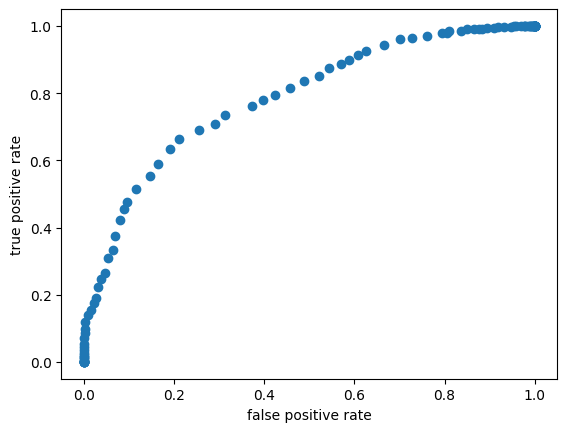

In [28]:
plt.scatter(pivot_test.y,pivot_test.x)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

In [29]:
AUC_testresnet50=np.abs(np.trapz(pivot_test.x,pivot_test.y))
print(AUC_testresnet50)

0.786918
